**Reto**

Imagínate que trabajas para un banco y éste tiene un problema importante: **los clientes se marchan**.  

A tu equipo le han encargado entender el porqué se marchan y ver si se puede hacer algo para, proactivamente, ir a aquellos clientes que tienen una posibilidad alta de marcharse y ofrecerles algún producto o servicio para evitarlo. La tarea que te han asignado es la de estudiar y entender el dataset que te han proporcionado y emplear diferentes técnicas para poder estar en las mejores condiciones para después entrenar un modelo predictivo

### 1. Preprocesamiento de los datos y Estudio inicial

##### Análisis de muestras y variables.

In [378]:
import pandas as pd

# Carga del dataset
dataset_path = "data/r1_data_2024.csv"
df_original = pd.read_csv(dataset_path)
df = df_original.copy(deep=True)

print("Resumen del DataFrame:\n")
df.info()

# Determinar número de muestras y variables
num_muestras = df.shape[0]
num_variables = df.shape[1]

print(f"\nEl dataset contiene {num_muestras} muestras y {num_variables} variables.")

# Determinando el número de variables categóricas y numéricas
variables_categoricas = df.select_dtypes(include=['object', 'category']).shape[1]
variables_numericas = df.select_dtypes(include=['number']).shape[1]

print(f"De las {num_variables} variables, {variables_categoricas} son categóricas "
      f"y {variables_numericas} son numéricas.")


Resumen del DataFrame:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Id                         10127 non-null  int64  
 1   ClosedAccount              10127 non-null  object 
 2   Age                        10006 non-null  float64
 3   Gender                     10016 non-null  object 
 4   Education                  10127 non-null  object 
 5   CivilState                 10012 non-null  object 
 6   Salary                     10057 non-null  object 
 7   Product                    10127 non-null  int64  
 8   NumMonthsBeingClient       10127 non-null  int64  
 9   NumProductsClient          10127 non-null  int64  
 10  NumMonthsWithoutOperating  10127 non-null  int64  
 11  CreditLimit                10025 non-null  float64
 12  CreditNotPayed             10064 non-null  float64
 13  SumTransactionAmount  

<span style="color:darkblue">

* Notamos algunos valores nulos en columnas como 'Age', 'Gender', 'CivilState', 'Salary', 'CreditLimit', y 'CreditNotPayed'. 
  
* La columna 'Salary' parece ser de tipo objeto, lo cual podría indicar que los datos no están uniformemente formateados (por ejemplo, números representados como texto, posiblemente con símbolos de moneda o separadores de miles). Será necesario convertir esta columna a un formato numérico para su análisis.

In [379]:
# verifico contenido de atributo
for x in df["Salary"].unique(): 
    print(x)

$60K - $80K
Less than $40K
$80K - $120K
$40K - $60K
$120K +
Unknown
nan


<span style="color:darkblue">

* Identificamos valores `Unknown` y `nan`.

##### b) Se verifica y se eliminan valores nulos

In [380]:
import numpy as np


# Verificamos si al menos hay un valor nulo
tiene_nulos = df.isnull().any().any()
print(f"¿El dataset tiene valores nan? {'Sí' if tiene_nulos else 'No'}")

if tiene_nulos:
    df = df.dropna()
    num_muestras_despues = df.shape[0]
    print(f"\nDespués de eliminar filas con valores nulos, quedan {num_muestras_despues} muestras.")
else:
    print(f"El dataset original ahora contiene {df.shape[0]} muestras.")


¿El dataset tiene valores nan? Sí

Después de eliminar filas con valores nulos, quedan 9559 muestras.


##### c) ¿Existe algún sesgo por género en el df?

In [381]:
# buscamos la distribución de género
distribucion_genero = df['Gender'].value_counts(normalize=True) * 100

print(f"Distribución de género en el dataset (%): \n\n{distribucion_genero}")

Distribución de género en el dataset (%): 

Gender
F    52.923946
M    47.076054
Name: proportion, dtype: float64


<span style="color:darkblue"> 

Con una distribución de aproximadamente 53% de mujeres y 47% de hombres y en el contexto del problema planteado por el banco, la distribución de género no sugiere inmediatamente un sesgo significativo que afectaría la capacidad de analizar o predecir la fuga de clientes (churn). Sin embargo, la verdadera pregunta sobre la representatividad y el sesgo en este contexto es cómo estas características de género (y otras demográficas) se correlacionan con la probabilidad de cerrar cuentas, y si el modelo predictivo final no perpetúa ni se ve afectado por sesgos inadvertidos.

</span>


<br>
<br>

**d) Técnicas para Manejar Categorías "Unknown"**

<span style="color:darkblue">

* **Eliminación**: Si solo unas pocas muestras tienen "Unknown" como valor, se podría optar por eliminarlas. Sin embargo, esto podría no ser ideal si se pierde mucha información.
* **Imputación por la Categoría más Frecuente**: Es útil cuando se pueden asumir que los datos faltantes son aleatorios.
* **Categoría Propia**: En algunos casos, "Unknown" podría considerarse como una categoría propia si representa un grupo significativo y distinto de observaciones.
* **Modelado para Imputación**: Se podría utilizar modelos predictivos para imputar los valores "Unknown" basándote en otras variables del dataset.

Uso de `SimpleImputer` en sklearn: Específicamente diseñado para la imputación, SimpleImputer puede reemplazar fácilmente los valores faltantes por la media, mediana, la moda (para categóricas) u otro valor constante.

</span>



<br>
<br>

**Sustitución de "Unknown" por la Categoría más Frecuente**



In [382]:
from sklearn.impute import SimpleImputer
import numpy as np

# Reemplaza 'Unknown' por np.nan para que SimpleImputer pueda procesarlo
df.replace('Unknown', np.nan, inplace=True)

# Crea un imputer para reemplazar los valores faltantes por la categoría más frecuente
imputer = SimpleImputer(strategy='most_frequent')

for column in df.select_dtypes(include=['object']).columns:
    # La salida de fit_transform necesita ser adaptada para ser unidimensional
    df[column] = imputer.fit_transform(df[[column]]).ravel()


##### e) Modifico nombre de las categorías en columna Gender.

In [383]:
df['Gender'] = np.where(df['Gender'] == 'M', 'Masc', np.where(df['Gender'] == 'F', 'Fem', df['Gender']))

# Muestra las primeras filas para verificar los cambios
print(df['Gender'].unique())

['Masc' 'Fem']


##### f) Estudio de distribución de las variables.

In [384]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px


# Creación de la primera figura de subplots
fig1 = make_subplots(rows=1, cols=2, subplot_titles=("Distribución de las Edades", 
                                                     "Distribución de las Edades por Sexo"))

# i) Distribución de las edades de los clientes
age_hist = px.histogram(df, x='Age', nbins=50)
for trace in age_hist.data:
    fig1.add_trace(trace, row=1, col=1)

# ii) Distribución de las edades de los clientes por sexo
age_gender_hist = px.histogram(df, x='Age', color='Gender', barmode='overlay', nbins=50)
for trace in age_gender_hist.data:
    fig1.add_trace(trace, row=1, col=2)

fig1.update_layout(height=400, width = 900, showlegend=True, 
                   title_text="Análisis de Clientes del Banco - Edades y Sexo")
fig1.show()

# Creación de la tercera figura de subplots
fig2 = make_subplots(rows=1, cols=2, subplot_titles=("Distribución de Clientes por Educación", 
                                                     "Distribución de Clientes por Producto"))

# iii) Distribución de clientes que se han ido y que se han quedado por educación
education_hist = px.histogram(df, x='Education', color='ClosedAccount', barmode='group')
for trace in education_hist.data:
    fig2.add_trace(trace, row=1, col=1)

# iv) Distribución de clientes que se han ido y se han quedado por el producto asociado
product_hist = px.histogram(df, x='Product', color='ClosedAccount', barmode='group')
for trace in product_hist.data:
    fig2.add_trace(trace, row=1, col=2)

fig2.update_layout(height=400, width = 900, showlegend=True, 
                   title_text="Análisis de Clientes del Banco - Educación y Producto")
fig2.show()

# v) Distribución de clientes que se han ido y se han quedado por sexo
gender_churn_hist = px.histogram(df, x='Gender', color='ClosedAccount', 
                                 barmode='group', title="Distribución de Clientes por Sexo")
gender_churn_hist.update_layout(
    height=400,
    width=530,
    showlegend=True
)
gender_churn_hist.show()

# vi) Distribución de clientes por rango de ingresos y estado de la cuenta
salary_hist = px.histogram(df, x='Salary', color='ClosedAccount', barmode='group',
                            title="Distribución de Clientes por Rango de Ingresos")
salary_hist.update_layout(
    height=350,
    width=950,
    showlegend=True
)
salary_hist.show()


<span style="color:darkblue"> 

**Distribución de las Edades**:  
La mayoría de los clientes se concentran en un rango de edad de aproximadamente 40 a 60 años. Esto podría indicar que el banco atrae a clientes que están en la mitad de su carrera profesional o se están acercando a la jubilación, lo que puede estar relacionado con la necesidad de servicios financieros relacionados con la planificación del retiro.

**Distribución de las Edades por Sexo**:  
La distribución por edades parece ser similar entre los clientes masculinos y femeninos del banco.

**Distribución de Clientes por Sexo**:  
Hay una cantidad comparable de clientes de cada sexo, pero parece que hay más clientes femeninos que cierran cuentas en comparación con los masculinos. Esto podría ser un área para investigar más a fondo y entender las razones subyacentes de este comportamiento.

**Distribución de Clientes por Rango de Ingresos**:  
La mayoría de los clientes que han cerrado cuentas parecen estar en el segmento de ingresos más bajos. Esto podría indicar problemas de retención de clientes en segmentos de menores ingresos o podría reflejar el comportamiento natural de ese segmento demográfico.

**Distribución de Clientes por Educación**:  
Los clientes con educación "Graduate" parecen ser la mayoría, y entre estos, los que han cerrado cuentas son una porción menor. Esto podría sugerir que el banco retiene mejor a los clientes con niveles de educación más altos.

**Distribución de Clientes por Producto**:  
El producto 1 parece ser el más popularidad, pero también es el producto con el mayor número de clientes que han cerrado sus cuentas.

</span>

<br>

##### g) Analizamos por rango de edades de los clientes.


Vamos a convertir la variable `age` de integer a categórica en una columna nueva con rangos de 5 en 5

In [385]:

# Convierte 'Age' a una columna categórica con rangos de edad como strings
df['AgeRange'] = pd.cut(
    df['Age'],
    bins=range(int(df['Age'].min()), int(df['Age'].max()) + 5, 5),
    right=False
).astype(str)  # Convirtiendo a string

df = df.sort_values(by='AgeRange')

# Muestra los primeros registros para verificar la nueva columna
print(df[['Age', 'AgeRange']].head())


       Age  AgeRange
890   30.0  [26, 31)
1488  26.0  [26, 31)
3207  26.0  [26, 31)
9128  30.0  [26, 31)
5468  30.0  [26, 31)


##### h) Replicamos gráfica con la nueva columna de rangos de edad.

In [386]:

# Creación de la primera figura de subplots
fig1 = make_subplots(rows=1, cols=2, subplot_titles=("Distribución de las Edades", 
                                                     "Distribución de las Edades por Sexo"))

# i) Distribución de las edades de los clientes con rangos
age_range_hist = px.histogram(df, x='AgeRange')
for trace in age_range_hist.data:
    fig1.add_trace(trace, row=1, col=1)

# ii) Distribución de las edades de los clientes por sexo con rangos
age_range_gender_hist = px.histogram(df, x='AgeRange', color='Gender', barmode='overlay')
for trace in age_range_gender_hist.data:
    fig1.add_trace(trace, row=1, col=2)

fig1.update_layout(height=400, width=900, showlegend=True,
                   title_text="Análisis de Clientes del Banco - Edades y Sexo")
fig1.show()


##### i) Al revisar las gráficas, la última (iv) nos ha sorprendido.


<span style="color:darkblue"> 

Parece que hay un número significativamente más alto de clientes con un rango de ingresos "Menos de $40K" que han cerrado sus cuentas en comparación con otros rangos de ingresos. Este hallazgo puede sugerir que el banco podría estar perdiendo clientes en el segmento de ingresos más bajos. Esto podría ser debido a la insatisfacción con los servicios, mejores ofertas de la competencia, o necesidades financieras cambiantes que no están siendo satisfechas por los productos del banco.

</span>

##### j) Posibles dos soluciones.

<span style="color:darkblue"> 

Podría ser útil para el banco investigar por qué los clientes de ingresos más bajos están cerrando sus cuentas y si hay medidas que podrían implementarse para mejorar la retención de clientes en este segmento. Por ejemplo, revisar la estrategia de precios, las tarifas, el tipo de productos ofrecidos, y si estos están adaptados a las necesidades de los clientes de este segmento. Además, el banco podría considerar si está proporcionando un soporte adecuado para la educación financiera y el asesoramiento a los clientes con menos ingresos, lo que podría influir en su decisión de permanecer con el banco.

</span>

In [387]:
data_1 = df.copy(deep=True)

# Asigno nuevo índice
data_1.reset_index(drop=True, inplace=True)
data_1.head().T

,0,1,2,3,4
Id,779149683,779126658,769701258,709171308,789396783
ClosedAccount,NO,NO,NO,NO,NO
Age,30.0,26.0,26.0,30.0,30.0
Gender,Fem,Fem,Fem,Masc,Fem
Education,Graduate,Graduate,Graduate,High School,High School
CivilState,Divorced,Single,Married,Married,Single
Salary,Less than $40K,$40K - $60K,Less than $40K,$60K - $80K,Less than $40K
Product,1,1,1,1,1
NumMonthsBeingClient,13,13,18,16,20
NumProductsClient,5,5,3,1,3


### 2. Principal Component Analysis (PCA)


##### a) Elimino del dataset las columnas que contienen las IDs de los clientes

<span style="color:darkblue"> 

Utilizo el método `drop` para eliminar las columnas que contienen las IDs de los clientes (Id), si han cerrado la cuenta (ClosedAccount), y los rangos de edad (AgeRange).

</span>

In [388]:
# elimino columnas no deseadas
data_2 = data_1.drop(['Id', 'ClosedAccount', 'AgeRange'], axis=1)
data_2.head().T

,0,1,2,3,4
Age,30.0,26.0,26.0,30.0,30.0
Gender,Fem,Fem,Fem,Masc,Fem
Education,Graduate,Graduate,Graduate,High School,High School
CivilState,Divorced,Single,Married,Married,Single
Salary,Less than $40K,$40K - $60K,Less than $40K,$60K - $80K,Less than $40K
Product,1,1,1,1,1
NumMonthsBeingClient,13,13,18,16,20
NumProductsClient,5,5,3,1,3
NumMonthsWithoutOperating,1,1,3,3,3
CreditLimit,7772.0,5655.0,12463.0,15795.0,2112.0


##### b) Calculo la matriz de correlación del dataset

<span style="color:darkblue"> 

Para poder calcular la matriz de correlación, primero hay que convertir las columnas categóricas a un formato numérico que represente las categorías. Las variables categóricas nominales pueden ser convertidas usando técnicas como one-hot encoding. Las variables categóricas ordinales pueden ser asignadas a valores enteros que reflejen su orden y un método común es el ordinal encoding.  
<br>  

Podemos considerar nominales:
* Gender: ya que las categorías (Femenino, Masculino) no tienen un orden inherente.
* CivilState: Nominal, las categorías (Divorciado, Soltero, Casado) no tienen un orden natural.
* Product: Nominal si representa diferentes tipos o categorías de productos que no tienen un orden natural.

Podemos considerar ordinales:
* Education: (por ejemplo, Secundaria, Pregrado, Posgrado) se consideran tener un orden donde cada nivel es más avanzado que el anterior.
* Salary: las categorías representan rangos de ingresos que tienen un orden natural de menos a más.


In [390]:
# Convertir variables nominales a numéricas mediante one-hot encoding.
data_2_encoded = pd.get_dummies(data_2, columns=['Gender', 'Education', 'CivilState', 'Product'], drop_first=True)

# Convertir variables ordinales a numéricas.
salary_order = {'Less than $40K': 1, '$40K - $60K': 2, '$60K - $80K': 3, '$80K - $120K': 4, '$120K +': 5}
data_2_encoded['Salary'] = data_2['Salary'].map(salary_order)

data_2_encoded.head().T

,0,1,2,3,4
Age,30.0,26.0,26.0,30.0,30.0
Salary,1,2,1,3,1
NumMonthsBeingClient,13,13,18,16,20
NumProductsClient,5,5,3,1,3
NumMonthsWithoutOperating,1,1,3,3,3
CreditLimit,7772.0,5655.0,12463.0,15795.0,2112.0
CreditNotPayed,1890.0,0.0,1319.0,1742.0,1109.0
SumTransactionAmount,2585,2312,3996,13173,4729
NumTransactions,75,61,71,96,78
Gender_Masc,False,False,False,True,False


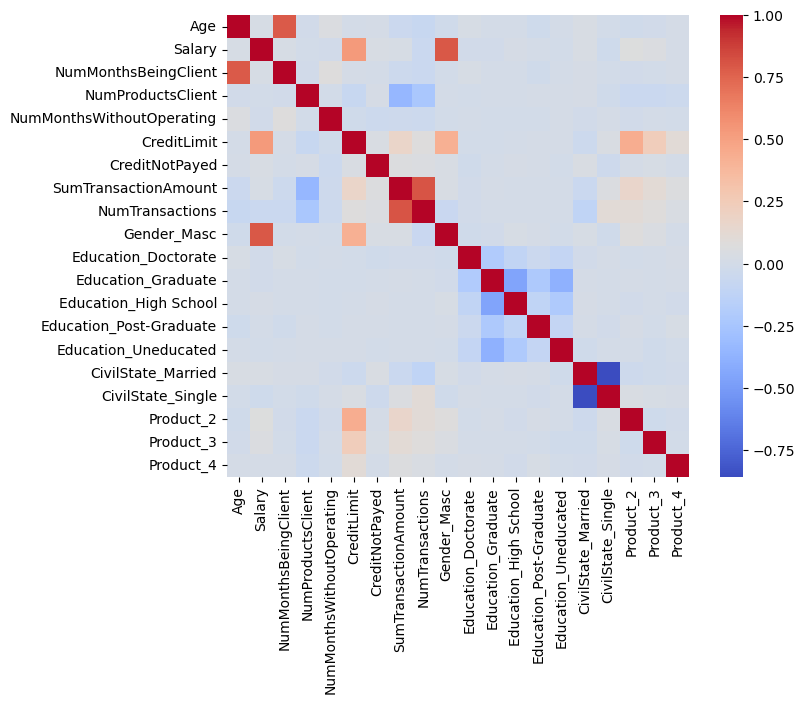

In [391]:
# Ahora se puede calcular la matriz de correlación.
correlation_matrix = data_2_encoded.corr()

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

# Crear el mapa de calor con seaborn
# 'annot=True' añade las etiquetas dentro de cada celda
# 'fmt='.2f' especifica el formato numérico para las anotaciones
sns.heatmap(correlation_matrix, fmt='.2f', cmap='coolwarm', square=True)

# Mostrar el gráfico
plt.show()

<span style="color:darkblue"> 

Este mapa de calor representa la matriz de correlación de las variables del DataFrame del +1 al 1. Los colores indican la fuerza y la dirección de la correlación entre pares de variables: los tonos rojos indican una correlación positiva, los azules una correlación negativa, y los colores más cercanos al blanco indican una correlación cercana a cero. La intensidad del color refleja la magnitud de la correlación.

* Correlaciones Fuertes Positivas (rojos intensos): Algunas variables como NumMonthsBeingClient y CreditLimit, NumMonthsBeingClient y NumProductsClient muestran fuertes correlaciones positivas. Esto podría indicar que cuanto más tiempo han sido clientes, tienden a tener un límite de crédito más alto y más productos con el banco.
* Correlaciones Fuertes Negativas (azules intensos): Sugiere una relación inversa marcada.
* Correlaciones Débiles (colores cercanos al blanco): Tienen muy poca o ninguna correlación lineal.


A veces crear nuevas variables a partir de las existentes en el dataset nos pueden ayudar a mejorar nuestros modelos predictivos. En este caso concreto, se propone crear una nueva variable llamada AvgAmountTransaction qué es la media de dinero usada en una transacción.

##### c) Se crea una nueva variable en una columna nueva del dataset. ¿Aporta valor lo que hemos hecho?


<span style="color:darkblue"> 


La nueva variable que se propone, "AvgAmountTransaction", se calcularía tomando el "SumTransactionAmount" y dividiéndolo por el "NumTransactions" para cada fila. Esto nos daría el promedio de dinero gastado por transacción.

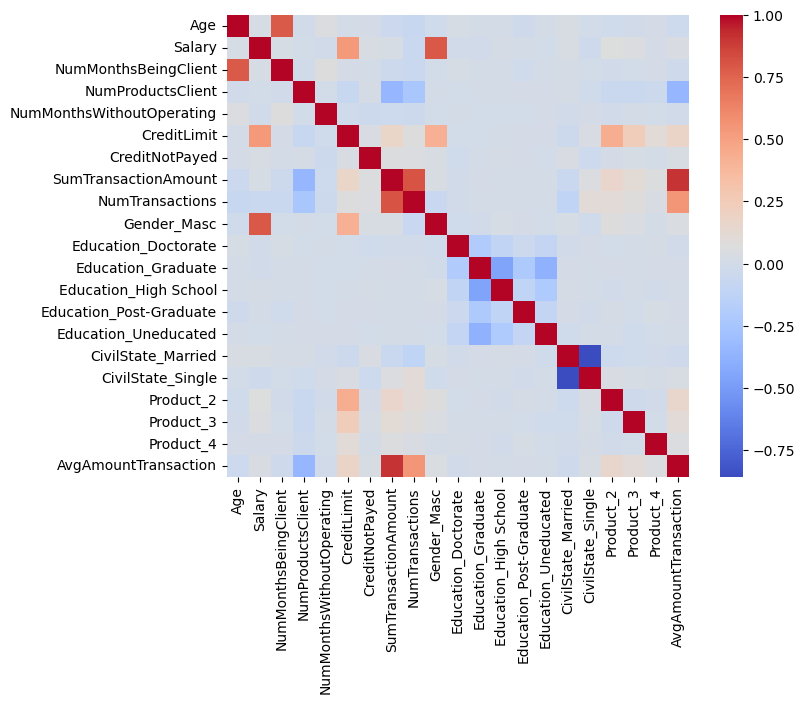

In [392]:

# Añado nueva variable
data_2_encoded['AvgAmountTransaction'] = data_2['SumTransactionAmount'] / data_2['NumTransactions']

# calculamos la matriz de correlación
matriz_correlacion = data_2_encoded.corr()

plt.figure(figsize=(8, 6))

# 'annot=True' añade las etiquetas dentro de cada celda
# 'fmt='.2f' especifica el formato numérico para las anotaciones
sns.heatmap(matriz_correlacion, fmt='.2f', cmap='coolwarm', square=True)

plt.show()


<span style="color:darkblue"> 

La presencia de celdas coloreadas en la fila y columna correspondientes a AvgAmountTransaction indica que existe cierto grado de relación lineal entre esta nueva variable y otras. Esto es información que no estaba disponible tan directamente antes de la creación de esta variable, ofrece una visión adicional sobre la relación entre el monto promedio de las transacciones y las otras variables en el dataset.

El valor que aporta es a varios niveles:

* **Relevancia práctica**: La variable AvgAmountTransaction es una métrica que representa la cantidad promedio gastada en una transacción, lo que puede ser más intuitivo y útil para el análisis de comportamiento del cliente que el monto total o el número total de transacciones por separado.
* **Análisis de correlación**: se pueden observar sus correlaciones con otras variables.
* **Potencial predictivo**: Si AvgAmountTransaction muestra una correlación sustancial con otras variables de interés, podría ser un predictor útil en modelos predictivos, ayudando a mejorar la precisión y el rendimiento del modelo.
* **Identificación de patrones**: Al entender cómo se relaciona el monto promedio de transacción con otras variables (por ejemplo, CreditLimit o NumProductsClient), las empresas pueden identificar patrones de gasto y adaptar sus estrategias de marketing o de riesgo crediticio en consecuencia.

</span>


Un compañero del equipo ha hecho un par de pruebas con el dataset y ha visto que quizás obtendremos mejores resultados haciendo una reducción de la dimensionalidad de los datos. Ha sugerido realizar un PCA en el dataset pero tú ves que tenemos variables categóricas y que provocaría ciertos errores. Para solucionar este problema, tenemos diferentes opciones como por ejemplo transformar aquellas variables categóricas a formato one-hot-encoding.


##### d) qué nos aporta el uso del PCA.

¿Crees que será útil aplicar una técnica de reducción de dimensionalidad a nuestro dataset? ¿Por qué?

<span style="color:darkblue"> 

Un análisis PCA nos puede aportar: 

* **Reducción de ruido**: Al reducir la dimensionalidad, PCA puede ayudar a eliminar el "ruido" de los datos y resaltar las características más importantes.
* **Visualización de datos**: Con muchas variables, es difícil visualizar los datos y detectar patrones. PCA puede reducir el número de variables a 2 o 3 componentes principales que se pueden representar en gráficos bidimensionales o tridimensionales.
* **Eficiencia computacional**: Menos dimensiones significan menos cálculos, lo que puede ser esencial para el análisis de grandes datasets y puede mejorar la eficiencia de los algoritmos de aprendizaje automático.
* **Evitar la colinealidad**: PCA también puede ayudar a evitar problemas de multicolinealidad en los modelos de regresión al crear componentes que son ortogonales (independientes) entre sí.
* **Mejor comprensión de las estructuras ocultas**: Al enfocarse en las principales fuentes de variación en los datos, PCA puede revelar estructuras ocultas que no eran aparentes inicialmente.
  

</span>


##### e) Otra técnica de reducción de dimensionalidad es el TSNE. ¿Qué técnica, para este caso de uso en particular, crees que es la más recomendable?

<span style="color:darkblue"> 

* **PCA** es una técnica lineal que reduce la dimensionalidad encontrando los ejes con la mayor varianza, es rápida y adecuada para visualización general y para preparar datos para modelos de aprendizaje automático en datasets grandes.

* **t-SNE** es una técnica no lineal que es excelente para visualizar clusters y patrones complejos en datasets más pequeños, pero es más lenta y no tan adecuada para datasets muy grandes o para reducir dimensiones antes de entrenar modelos.

Para este caso, PCA es más recomendable si se va a modelar predictivamente. t-SNE es mejor si el enfoque está en explorar visualmente los datos y el dataset es de un tamaño manejable. Dado que nos han encargado diferentes técnicas para poder entrenar un modelo predictivo, se conluye que PCA es la mejor opción en este caso.</span>

</span>


##### f) y g) Borrando atributo 'AvgAmountTransaction'. One-hot-encoding & Ordinal encoding

<span style="color:darkblue"> 

En el **apartado b)** tuvimos que calcular la matriz de correlación en un dataset con variables categóricas, y efectivamente tuvimos que convertirlas a un formato numérico. 

* **One-hot encoding** para variables categóricas nominales sin orden inherente, como Gender, CivilState, y Product. Esto creará una nueva columna binaria para cada categoría.
* **Ordinal encoding** para variables categóricas ordinales que tienen un orden natural, como Education y Salary, donde los valores se asignan en función del orden.

</span>

In [393]:
data_2_encoded.drop('AvgAmountTransaction', axis=1, inplace=True)
data_2_encoded.head().T

,0,1,2,3,4
Age,30.0,26.0,26.0,30.0,30.0
Salary,1,2,1,3,1
NumMonthsBeingClient,13,13,18,16,20
NumProductsClient,5,5,3,1,3
NumMonthsWithoutOperating,1,1,3,3,3
CreditLimit,7772.0,5655.0,12463.0,15795.0,2112.0
CreditNotPayed,1890.0,0.0,1319.0,1742.0,1109.0
SumTransactionAmount,2585,2312,3996,13173,4729
NumTransactions,75,61,71,96,78
Gender_Masc,False,False,False,True,False


##### h) PCA

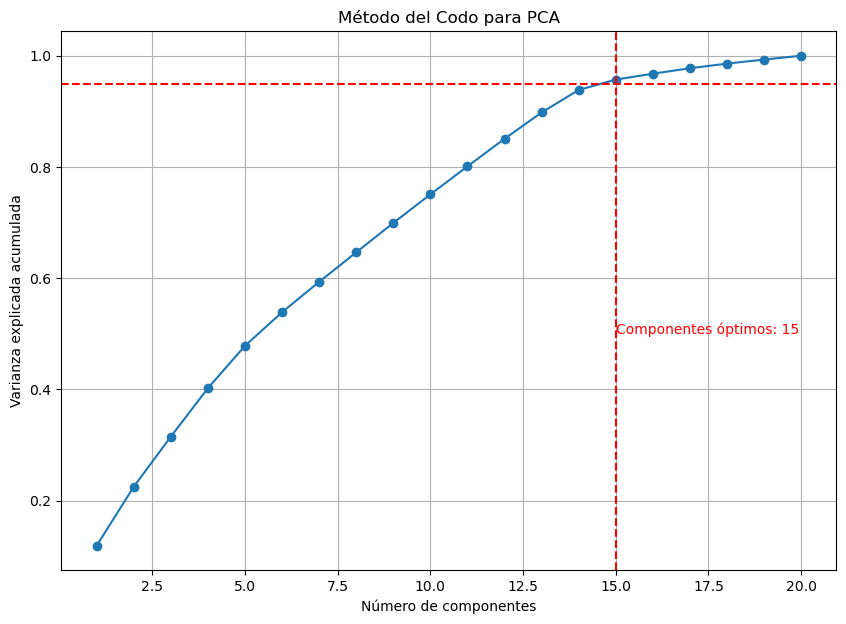

In [394]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np


# Estandarizar los datos
scaler = StandardScaler()
data_2_standardized = scaler.fit_transform(data_2_encoded)

# Ajustar el PCA
pca = PCA().fit(data_2_standardized)

# Varianza explicada acumulada
cumulative_variance = pca.explained_variance_ratio_.cumsum()

# Identificar el codo con el método de la varianza explicada
percent_variance_to_keep = 0.95
components_needed = np.argmax(cumulative_variance >= percent_variance_to_keep) + 1

# Graficar el método del codo
plt.figure(figsize=(10, 7))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.axhline(y=percent_variance_to_keep, color='r', linestyle='--')
plt.axvline(x=components_needed, color='r', linestyle='--')
plt.text(components_needed, 0.5, f'Componentes óptimos: {components_needed}', color = 'red')
plt.title('Método del Codo para PCA')
plt.xlabel('Número de componentes')
plt.ylabel('Varianza explicada acumulada')
plt.grid(True)
plt.show()


<span style="color:darkblue"> 

La gráfica muestra la varianza explicada acumulada en función del número de componentes del PCA. Lo que indica es cuánta información (varianza) se retiene al usar un cierto número de componentes principales.

En cuanto a la reducción de dimensionalidad, sí, se ha logrado. Según el gráfico, se necesita aproximadamente 15 componentes para explicar el 95% de la varianza en los datos. Esto se ve donde la línea vertical cruza la curva de varianza acumulada. Por lo tanto, se puede reducir la dimensionalidad de loss datos de 20 variables originales a 15 componentes principales sin perder una cantidad significativa de información. Esto es útil para simplificar datos y posiblemente mejorar el rendimiento de los algoritmos de aprendizaje automático, especialmente aquellos que son sensibles a la "maldición de la dimensionalidad".

</span>


### 3. Las habilidades más importantes de los científicos de datos

[The most important skills of data scientists](https://www.youtube.com/watch?v=qrhRfPY4F4w&t=90s) | Jose Miguel Cansado | TEDxIEMadrid

##### a) Según este artículo ¿qué nos ha aportado a la sociedad la ciencia de datos?

<span style="color:darkblue"> 

Según el artículo, la ciencia de datos ha aportado a la sociedad la capacidad de manejar, procesar y analizar enormes cantidades de información con la ayuda de la inteligencia artificial, el aprendizaje automático y las tecnologías de big data. Este poder se está utilizando de diversas maneras, incluyendo la mejora del perfilado de usuarios, la realización de recomendaciones personalizadas, el avance de la atención médica y el diagnóstico, la predicción de revoluciones políticas, la prevención del crimen, la creación de bellas artes, entre otros. En esencia, el big data se está aprovechando para realzar el potencial humano y generar conocimientos prácticos que pueden marcar la diferencia en varios campos.


</span>

#### b) ¿porqué la curiosidad es el cetro del científuco de datos según este artículo?

<span style="color:darkblue"> 

 La curiosidad se menciona como el núcleo de las cualidades de un científico de datos porque es la fuerza motriz detrás de las habilidades clave necesarias para transformar los datos en conocimientos. Es la curiosidad la que conduce a la empatía, que es crucial para comprender las necesidades de los demás. La curiosidad alimenta la imaginación para visualizar lo que aún no existe y la creatividad para inventar soluciones a los problemas. Impulsa la comunicación para influir y persuadir a otros, y lleva al liderazgo que puede inspirar a la acción. Lo más importante es que la curiosidad es esencial para hacer las preguntas correctas a los datos, iterar para comprender los problemas humanos, imaginar posibilidades, crear soluciones y comunicar efectivamente los conocimientos para que sean accionables. Este conjunto de habilidades, arraigado en la curiosidad, es lo que hace que el elemento humano en la ciencia de datos sea insustituible por la inteligencia artificial, al menos por ahora.

</span>

##### c) Se sugieren otras 2 variables para investigación del problema.

<span style="color:darkblue"> 

Crear dos atributis más  podrían capturar otros aspectos del comportamiento de los clientes que no se reflejan en las variables originales:

**CreditUtilizationRate**: Esta sería la proporción del límite de crédito que está siendo utilizada. Se calcula dividiendo el CreditNotPayed por el CreditLimit. Una tasa alta de utilización del crédito puede ser indicativa de sobreendeudamiento o comportamiento financiero arriesgado, mientras que una tasa baja puede indicar un buen manejo del crédito.

$$
\text{Fórmula}: CreditUtilizationRate = CreditNotPayed / CreditLimit
$$

**ClientStabilityIndex**: Este índice podría ser una combinación de NumMonthsBeingClient y NumMonthsWithoutOperating. Esta variable buscaría reflejar la estabilidad y la actividad del cliente con la entidad. Por ejemplo, se podría crear un índice que penalice la falta de operaciones en los últimos meses a pesar de una larga relación con la entidad.

$$
\text{Fórmula}: ClientStabilityIndex = NumMonthsBeingClient / (1 + NumMonthsWithoutOperating)
$$

Esta fórmula da un valor más alto a los clientes con una larga relación y actividad reciente, y un valor más bajo a aquellos con la misma antigüedad pero sin actividad reciente.

Después de crear estas variables, sería importante realizar un análisis para validar su utilidad y asegurarse de que mejoran el modelo predictivo sin causar sobreajuste.


</span>